# Examples

This demo shows how `roc_utils` is used to compute and visualize [ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) curves. First, we need some prerequisites.

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath(".."))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from roc_utils import *

For the examples below, we will use the following data generator.

In [3]:

def sample_data(n1, mu1, std1, n2, mu2, std2, seed=42):
    """
    Construct binary classification problem with n1 and n2 
    samples per class, respectively. 
    
    Returns two np.ndarrays x and y of length (n1+n2). 
    x represents the predictor, y the binary response.
    """
    rng = np.random.RandomState(seed)
    #  sample size, mean, std
    x1 = rng.normal(mu1, std1, n1)
    x2 = rng.normal(mu2, std2, n2)
    y1 = np.zeros(n1, dtype=bool)
    y2 = np.ones(n2, dtype=bool)
    x = np.concatenate([x1,x2])
    y = np.concatenate([y1,y2])
    return x, y

## Basic usage example

Let's start with generating and visualizing some data.


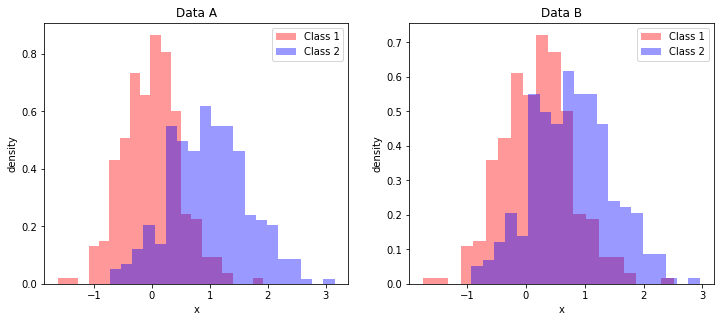

In [4]:
# Construct binary classification problem
x1, y1 = sample_data(n1=300, mu1=0.0, std1=0.5,
                     n2=300, mu2=1.0, std2=0.7)
x2, y2 = sample_data(n1=300, mu1=0.2, std1=0.6,
                     n2=300, mu2=0.8, std2=0.7)

# Show data
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.8))
ax1.hist(x1[y1==False], bins=20, density=True,
         color="red", alpha=0.4, label="Class 1")
ax1.hist(x1[y1==True], bins=20, density=True,
         color="blue", alpha=0.4, label="Class 2")
ax1.legend()
ax1.set_xlabel("x")
ax1.set_ylabel("density")
ax1.set_title("Data A")
ax2.hist(x2[y2==False], bins=20, density=True,
         color="red", alpha=0.4, label="Class 1")
ax2.hist(x2[y2==True], bins=20, density=True,
         color="blue", alpha=0.4, label="Class 2")
ax2.legend()
ax2.set_title("Data B")
ax2.set_xlabel("x")
ax2.set_ylabel("density");

For a ROC analysis, it is required to specify a positive class label. In this demo, we set `pos_label = True`. 

To compute a ROC curve, we simply call `compute_roc()`.

In [5]:
pos_label = True
roc1 = compute_roc(X=x1, y=y1, pos_label=pos_label)
roc2 = compute_roc(X=x2, y=y2, pos_label=pos_label)

This returns struct-like objects (`roc1`, `roc2`) with some relevant information about the ROC curves. For example, we can access the area under the ROC curve (ROC-AUC, or simply AUC) as follows:

In [6]:
print("Data 1: ROC-AUC=%.3f" % (roc1.auc))
print("Data 2: ROC-AUC=%.3f" % (roc2.auc))

Data 1: ROC-AUC=0.885
Data 2: ROC-AUC=0.745


For a list of available keys, call `list(roc1.keys())`.

- `thr`: thresholds (parametrization variable)
- `fpr`: false positive rates `fpr(thr)` (the "x-vals")
- `tpr`: true positive rates `tpr(thr)` (the "y-vals")
- `auc`: area under curve
- `opd`: a dictionary describing optimal point(s)
- `inv`: True if inverted predictor was detected (`auto_flip`, see below)

Find the section Miscellaneous below further information on the objectives/optimal points and auto-flipping of the ROC curve.

In [7]:
print("Available keys:", list(roc1.keys()))

Available keys: ['fpr', 'tpr', 'thr', 'auc', 'opd', 'inv']


Plotting the ROC curve is just as easy:

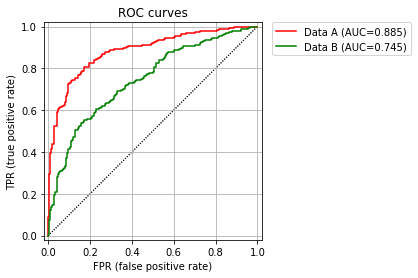

In [8]:
_, ax3 = plt.subplots()
plot_roc(roc1, label="Data A", color="red", ax=ax3)
plot_roc(roc2, label="Data B", color="green", ax=ax3)
# Place the legend outside.
ax3.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
ax3.set_title("ROC curves");


## Aggregate multiple ROC curves

Sometimes it is required to compute the average ROC curve for different datasets or repeated evaluations in a cross-validation setup. For this purpose, `roc_utils` offers the functions `compute_mean_roc()` and `plot_mean_roc()`.

Let's first create `n_datasets` datasets compute the ROC curves for each dataset instance. Then, `compute_mean_roc()` is used to aggregate this list of ROC curves.

In [9]:
pos_label = True
n_datasets = 20
rocs = []
for i in range(n_datasets):
    x, y = sample_data(n1=300, mu1=0.0, std1=0.5,
                       n2=300, mu2=1.0, std2=0.7, seed=i)
    roc = compute_roc(X=x, y=y, pos_label=pos_label)
    rocs.append(roc)
    
roc_mean = compute_mean_roc(rocs)

In principle, it is possible to plot this average ROC curve the same way as already demonstrated.

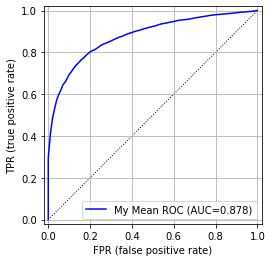

In [10]:
plot_roc(roc_mean, label="My Mean ROC", color="blue")

Alternatively, use `plot_mean_roc()` to also visualize the [confidence interval (CI)](https://en.wikipedia.org/wiki/Confidence_interval) and the [tolerance intervals (TI)](https://en.wikipedia.org/wiki/Tolerance_interval).

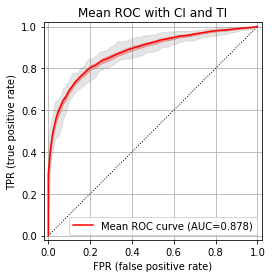

In [11]:
plot_mean_roc(rocs, show_ci=True, show_ti=True)
plt.title("Mean ROC with CI and TI");

It is also possible to plot all ROC curves individually along with the mean ROC curve.

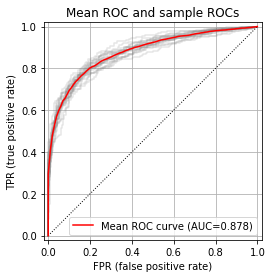

In [12]:
plot_mean_roc(rocs, show_ci=False, show_ti=False, show_all=True)
plt.title("Mean ROC and sample ROCs");

## Bootstrapped ROC analysis

It is possible to compute the ROC curves for [bootstrap samples](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) of the input dataset `(x,y)`.

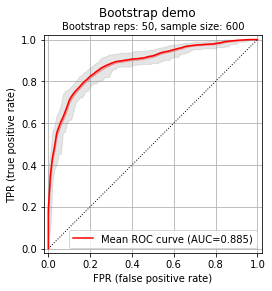

In [13]:
pos_label = True
n_samples = 50
x, y = sample_data(n1=300, mu1=0.0, std1=0.5,
                   n2=300, mu2=1.0, std2=0.7)
plot_roc_bootstrap(X=x, y=y, pos_label=pos_label,
                   n_bootstrap=n_samples,
                   random_state=42,
                   show_boots=False,
                   title="Bootstrap demo");

If one wants to separate computation from visualization, it is possible to achieve the same in two steps.

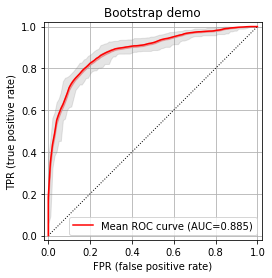

In [14]:
rocs = compute_roc_bootstrap(X=x, y=y, pos_label=pos_label,
                             n_bootstrap=n_samples,
                             random_state=42,
                             return_mean=False)
plot_mean_roc(rocs, show_ci=True, show_ti=True)
plt.title("Bootstrap demo");

## Miscellaneous


### `objective`

Based on the ROC analysis, it is possible to identify a cut-off threshold `thr_c` that maximizes some optimality criterion J. Several alternatives are available. The default choice `"minopt"`. See the code documentation of `get_objective()` for the details.

- `minopt`: Computes the distance from the optimal point (0,1). J = (fpr^2 + (1-tpr)^2)^(1/2)
- `minoptsym`: Similar as "minopt", but takes the smaller of the distances from points (0,1) and (1,0).
- `youden`: Maximize the Youden's index: J = sensitivity + specitivity - 1. Youden's index can be visualized as the distance from the diagonal in vertical direction.
- `cost`: Maximize the distance from the diagonal (fpr=tpr)
- `concordance`: Optimize the objective J = sensitivity * specitivity = tpr * (1-fpr). The concordance can be visualized as the rectangular formed by tpr and (1-fpr).
- `lr+`: Optimize the positive likelihood ratio J = tpr / fpr
- `lr-`: Optimize the Negative likelihood ratio J = fnr / tnr = (1-tpr) / (1-fpr)
- `dor`: Optimize the diagnostic odds ratio J = LR+/LR-
- `chi2`: Maximize the standard chi-square statistic with one degree of freedom
- `acc`: Maximize prediction accuracy J = (TP+TN)/(P+N)
- `cohen`: Maximize the "agreement" between binarized `x` and labels `y`. (Slow)

Recall that true positive rate `tpr` is also known as *recall* or *sensitivity*, whereas the false positive rate `fpr`  can be written as 1 - specificity.

The objectives `minopt`, `youden` and `cost` likely are the same in most cases.

minopt:         thr= 0.411, J= -0.260
minoptsym:      thr= 0.411, J= -0.260
youden:         thr= 0.414, J=  0.633
cost:           thr= 0.414, J=  0.633
concordance:    thr= 0.411, J=  0.667
acc:            thr= 0.414, J=  0.817
cohen:          thr= 0.414, J=  0.633


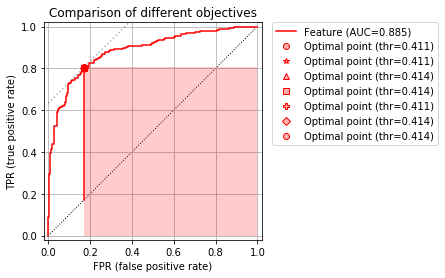

In [15]:
# Note that multiple objective functions can be computed at the same time.
pos_label = True
x, y = sample_data(n1=300, mu1=0.0, std1=0.5,
                   n2=300, mu2=1.0, std2=0.7)

roc = compute_roc(X=x, y=y, pos_label=pos_label,
                  objective=["minopt", "minoptsym", 
                             "youden", "cost",
                             "concordance",
                             #"lr+", "lr-",    # Possibly buggy
                             #"dor", "chi2",   # Possibly buggy
                             "acc", "cohen"])
for key, val in roc.opd.items():
    print("%-15s thr=% .3f, J=%7.3f" % (key+":", val.opt, val.opo) )
    
plot_roc(roc, show_opt=True)
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.title("Comparison of different objectives");

### `auto_flip`

If for some stupid reason, the feature x predicts "the other" label, one can use the argument `auto_flip` to adjust for this.

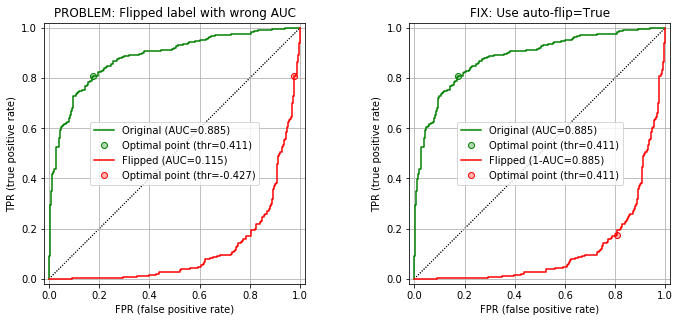

In [16]:
pos_label = True
x, y = sample_data(n1=300, mu1=0.0, std1=0.5,
                   n2=300, mu2=1.0, std2=0.7)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4.8))
roc1 = compute_roc(X=x, y=y, pos_label=pos_label)
roc2 = compute_roc(X=x, y=y, pos_label=not pos_label)
plot_roc(roc1, show_opt=True, label="Original", color="green", ax=ax1)
plot_roc(roc2, show_opt=True, label="Flipped", color="red", ax=ax1)
ax1.set_title("PROBLEM: Flipped label with wrong AUC")
ax1.legend(loc="center")

roc1 = compute_roc(X=x, y=y, pos_label=pos_label)
roc2 = compute_roc(X=x, y=y, pos_label=not pos_label, auto_flip=True)
plot_roc(roc1, show_opt=True, label="Original", color="green", ax=ax2)
plot_roc(roc2, show_opt=True, label="Flipped", color="red", ax=ax2)
ax2.set_title("FIX: Use auto-flip=True")
legend = ax2.legend(loc="center")
